# Initial calibration

### Setup

In [2]:
import logging, logging.config
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import pickle
import numpy as np
import pandas as pd
# import pystan
import yaml

from simulation_utils.calibration import compute_cosine_corr, _sample_pairs
from simulation_utils.preference import generate_lda, generate_ibp_itemwise
from simulation_utils.observation import sample_uniform_n, sample_popular_n
from simulation_utils.utils import truncated_beta_binomial, truncated_pareto, compile_stan_model
from simulation_utils.preference import generate_ibp_nbp
from simulation_utils.datasets import ml_100k

import simulation_utils as sims_utils
%matplotlib inline

### Read data

In [4]:
data = ml_100k()
nusers = len(data['user'].unique())
nitems = len(data['item'].unique())

In [5]:
print(nusers, nitems)

943 1682


In [6]:
data.head()

user  item  rating
0   196   242       3
1   186   302       3
2    22   377       1
3   244    51       2
4   166   346       1

### Check point

In [7]:
fname = 'calibrations_lda_pop.*07.*.pkl'

In [8]:
def read_calibrations(name):
    import os
    import re
    pattern = re.compile(name)
    filenames = [fn for fn in os.listdir('build') if pattern.match(fn)]
    print(', '.join(filenames))
    results = []
    for fn in filenames:
        path = os.path.join('build', fn)
        with open(path, 'rb') as f:
            result = pickle.load(f)
        results.extend(result)
    return pd.DataFrame(results)

In [9]:
res_df = read_calibrations(fname)

calibrations_lda_pop_2019-03-07-15-49-34.pkl


In [10]:
res_df.head()

item_popularity_kl_divergence               obs     obs_a  obs_alpha  \
0                       0.232513  sample_popular_n       NaN   0.510528   
1                       0.220110  sample_popular_n  0.000017        NaN   
2                       0.187721  sample_popular_n       NaN   0.510528   
3                       0.176924  sample_popular_n  0.000017        NaN   
4                       0.367473  sample_popular_n       NaN   0.510528   

      obs_b            obs_dist_func  obs_m  obs_n  obs_use_cap          pref  \
0       NaN         truncated_pareto   20.0    NaN         True  generate_lda   
1  2.815789  truncated_beta_binomial    NaN  737.0         True  generate_lda   
2       NaN         truncated_pareto   20.0    NaN         True  generate_lda   
3  2.815789  truncated_beta_binomial    NaN  737.0         True  generate_lda   
4       NaN         truncated_pareto   20.0    NaN         True  generate_lda   

   pref_a  pref_b  pref_c  pref_d  pref_k    pref_lam  pref_nitems  \
0       1       1       1       1       8  790.224157         1682   
1       1       1       1       1       8  790.224157         1682   
2       1       1       1       2       8  790.224157         1682   
3       1       1       1       2       8  790.224157         1682   
4       1       1       2       1       8  790.224157         1682   

   pref_nusers  user_activity_kl_divergence  
0          943                     0.181785  
1          943                     0.138823  
2          943                     0.180108  
3          943                     0.162863  
4          943                     0.184437

In [11]:
res_df.shape

(3200, 19)

In [12]:
res_df[res_df['item_popularity_kl_divergence'] < 2].sort_values(['item_popularity_kl_divergence', 'user_activity_kl_divergence']).head(10)

item_popularity_kl_divergence               obs     obs_a  obs_alpha  \
67                        0.155946  sample_popular_n  0.000017        NaN   
19                        0.162721  sample_popular_n  0.000017        NaN   
42                        0.163111  sample_popular_n       NaN   0.510528   
11                        0.165963  sample_popular_n  0.000017        NaN   
266                       0.173966  sample_popular_n       NaN   0.510528   
35                        0.174491  sample_popular_n  0.000017        NaN   
59                        0.174748  sample_popular_n  0.000017        NaN   
3                         0.176924  sample_popular_n  0.000017        NaN   
73                        0.177058  sample_popular_n  0.000017        NaN   
91                        0.177948  sample_popular_n  0.000017        NaN   

        obs_b            obs_dist_func  obs_m  obs_n  obs_use_cap  \
67   2.815789  truncated_beta_binomial    NaN  737.0         True   
19   2.815789  truncated_beta_binomial    NaN  737.0         True   
42        NaN         truncated_pareto   20.0    NaN         True   
11   2.815789  truncated_beta_binomial    NaN  737.0         True   
266       NaN         truncated_pareto   20.0    NaN         True   
35   2.815789  truncated_beta_binomial    NaN  737.0         True   
59   2.815789  truncated_beta_binomial    NaN  737.0         True   
3    2.815789  truncated_beta_binomial    NaN  737.0         True   
73   2.815789  truncated_beta_binomial    NaN  737.0         True   
91   2.815789  truncated_beta_binomial    NaN  737.0         True   

             pref  pref_a  pref_b  pref_c  pref_d  pref_k     pref_lam  \
67   generate_lda       1       1       1       2       8   820.729662   
19   generate_lda       2       1       1       2       8   790.224157   
42   generate_lda       1       2       1       2       8   810.214904   
11   generate_lda       1       2       1       2       8   790.224157   
266  generate_lda       1       2       1       2       8  1329.014944   
35   generate_lda       1       1       1       2       8   810.214904   
59   generate_lda       2       2       1       2       8   810.214904   
3    generate_lda       1       1       1       2       8   790.224157   
73   generate_lda       1       2       1       1       8   820.729662   
91   generate_lda       2       2       1       2       8   820.729662   

     pref_nitems  pref_nusers  user_activity_kl_divergence  
67          1682          943                     0.163256  
19          1682          943                     0.167795  
42          1682          943                     0.187762  
11          1682          943                     0.152607  
266         1682          943                     0.171858  
35          1682          943                     0.163745  
59          1682          943                     0.143885  
3           1682          943                     0.162863  
73          1682          943                     0.171028  
91          1682          943                     0.170695

In [13]:
res_df[res_df['item_popularity_kl_divergence'] < 2].sort_values(['user_activity_kl_divergence', 'item_popularity_kl_divergence']).head(20)

item_popularity_kl_divergence               obs     obs_a  obs_alpha  \
12                         0.320590  sample_popular_n       NaN   0.510528   
2649                       0.303327  sample_popular_n  0.000017        NaN   
3119                       0.507330  sample_popular_n  0.000017        NaN   
2535                       0.578275  sample_popular_n  0.000017        NaN   
531                        0.256915  sample_popular_n  0.000017        NaN   
1001                       0.282411  sample_popular_n  0.000017        NaN   
1983                       0.462248  sample_popular_n  0.000017        NaN   
1715                       0.226712  sample_popular_n  0.000017        NaN   
117                        0.422310  sample_popular_n  0.000017        NaN   
291                        0.222532  sample_popular_n  0.000017        NaN   
2399                       0.483363  sample_popular_n  0.000017        NaN   
2751                       0.528568  sample_popular_n  0.000017        NaN   
2577                       0.295723  sample_popular_n  0.000017        NaN   
1375                       0.516631  sample_popular_n  0.000017        NaN   
2893                       0.662194  sample_popular_n  0.000017        NaN   
53                         0.345815  sample_popular_n  0.000017        NaN   
2103                       0.553724  sample_popular_n  0.000017        NaN   
3151                       0.520961  sample_popular_n  0.000017        NaN   
574                        0.579263  sample_popular_n       NaN   0.510528   
886                        0.491977  sample_popular_n       NaN   0.510528   

         obs_b            obs_dist_func  obs_m  obs_n  obs_use_cap  \
12         NaN         truncated_pareto   20.0    NaN         True   
2649  2.815789  truncated_beta_binomial    NaN  737.0         True   
3119  2.815789  truncated_beta_binomial    NaN  737.0         True   
2535  2.815789  truncated_beta_binomial    NaN  737.0         True   
531   2.815789  truncated_beta_binomial    NaN  737.0         True   
1001  2.815789  truncated_beta_binomial    NaN  737.0         True   
1983  2.815789  truncated_beta_binomial    NaN  737.0         True   
1715  2.815789  truncated_beta_binomial    NaN  737.0         True   
117   2.815789  truncated_beta_binomial    NaN  737.0         True   
291   2.815789  truncated_beta_binomial    NaN  737.0         True   
2399  2.815789  truncated_beta_binomial    NaN  737.0         True   
2751  2.815789  truncated_beta_binomial    NaN  737.0         True   
2577  2.815789  truncated_beta_binomial    NaN  737.0         True   
1375  2.815789  truncated_beta_binomial    NaN  737.0         True   
2893  2.815789  truncated_beta_binomial    NaN  737.0         True   
53    2.815789  truncated_beta_binomial    NaN  737.0         True   
2103  2.815789  truncated_beta_binomial    NaN  737.0         True   
3151  2.815789  truncated_beta_binomial    NaN  737.0         True   
574        NaN         truncated_pareto   20.0    NaN         True   
886        NaN         truncated_pareto   20.0    NaN         True   

              pref  pref_a  pref_b  pref_c  pref_d  pref_k     pref_lam  \
12    generate_lda       1       2       2       1       8   790.224157   
2649  generate_lda       2       2       1       1     161   820.729662   
3119  generate_lda       1       2       2       2     168  1208.251496   
2535  generate_lda       1       1       2       2     153  1522.917112   
531   generate_lda       2       1       1       2      28  1176.079982   
1001  generate_lda       1       2       1       1      58   810.214904   
1983  generate_lda       2       2       2       2     122   810.214904   
1715  generate_lda       2       1       1       2     113  1039.191235   
117   generate_lda       2       1       2       1       8  1039.191235   
291   generate_lda       1       1       1       2       8  1522.917112   
2399  generate_lda       2       2       2       2     153  1061.999893

In [16]:
res_df.head()

item_popularity_kl_divergence             ...             user_activity_kl_divergence
0                       0.407067             ...                                0.681843
1                       0.399358             ...                                0.698168
2                       0.239211             ...                                0.232102
3                       0.209865             ...                                0.235659
4                       0.237683             ...                                0.214983

[5 rows x 15 columns]

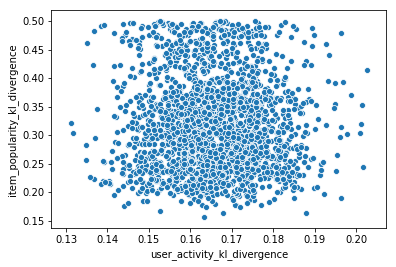

In [14]:
sns.scatterplot('user_activity_kl_divergence', 'item_popularity_kl_divergence', data=res_df[res_df['item_popularity_kl_divergence'] < 0.5])

### KL divergence vs. parameters

In [15]:
def plot_scatter3d(x, y, z, c, **kwargs):
    ax = plt.gca()
    kwargs.pop('color')
    zlabel = kwargs.pop('zlabel')
    p = ax.scatter(x, y, z, c=c, **kwargs)
#     plt.colorbar(p, shrink=0.5, aspect=5)
    ax.set_zlabel(zlabel)

In [16]:
def stats_vs_params(data, params, stat_names=('item_popularity_kl_divergence', 'user_activity_kl_divergence'), cmap_name=None):
    columns = []
    columns.extend(params)
    columns.extend(stat_names)
    data_tall = data[columns].melt(id_vars=params, value_vars=stat_names, var_name='stats', value_name='score')
    plt_params = [x for x in params if x != 'obs_dist_func']
    plt_param_labels = [x.replace('pref_', '') for x in plt_params]
    plt_param_labels = [''.join(['$\\', x, '$']) if x in ['alpha', 'sigma', 'lambda'] else x for x in plt_param_labels]
    for i, p in enumerate(plt_params):
        g = sns.FacetGrid(data_tall, col='obs_dist_func', row='stats', hue='stats', height=6, sharey=False, margin_titles=True)
        g = (g.map(sns.scatterplot, p, 'score')
             .add_legend()
             .set_axis_labels(plt_param_labels[i], 'score'))
    # plot 3d
    if len(plt_params) == 2:
        plt_params.append('score')
        plt_param_labels.append('score')
    cmap = plt.get_cmap(cmap_name)
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array(data_tall['score'])
    g = sns.FacetGrid(data_tall, col='obs_dist_func', row='stats', height=6, margin_titles=True, subplot_kws=dict(projection='3d'))
#     print(plt_params)
    g = (g.map(plot_scatter3d, *plt_params, 'score', zlabel=plt_param_labels[-1], cmap=cmap)
         .set_titles(col_template='{col_name}')
         .set_axis_labels(*plt_param_labels[:2]))
    cax = g.fig.add_axes([1.05, 0.3, 0.075, 0.25])
    plt.colorbar(sm, cax=cax)

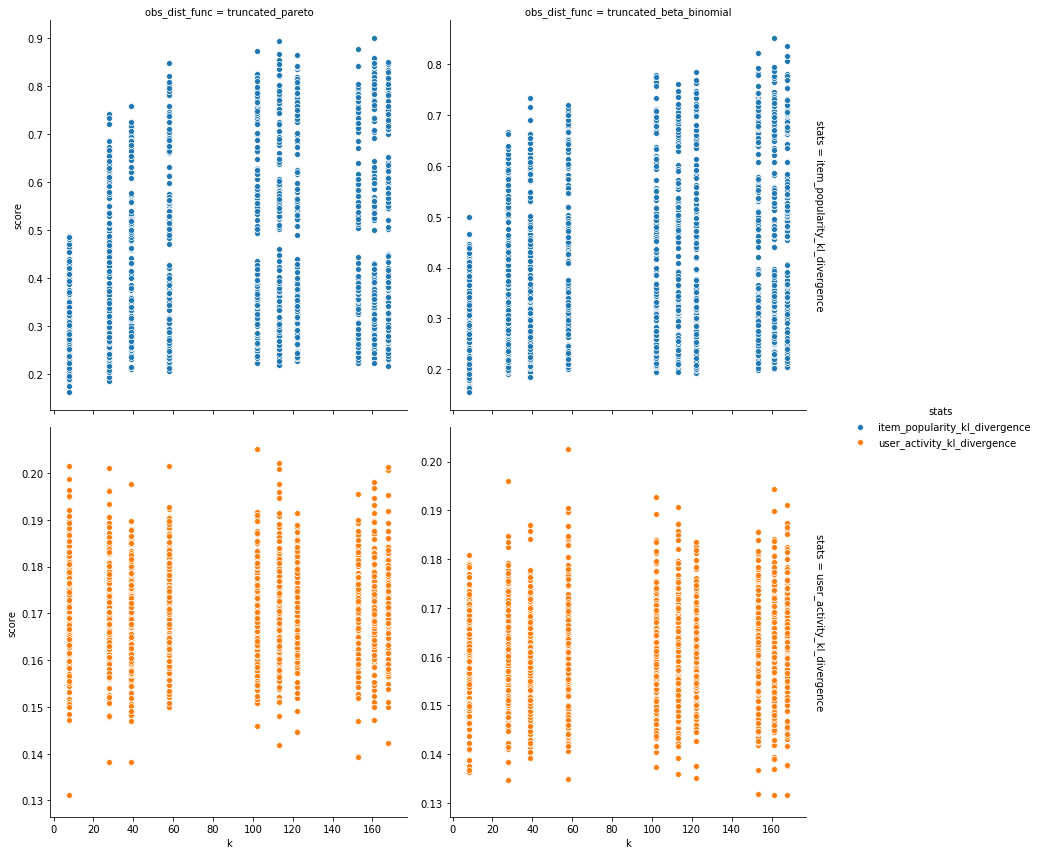

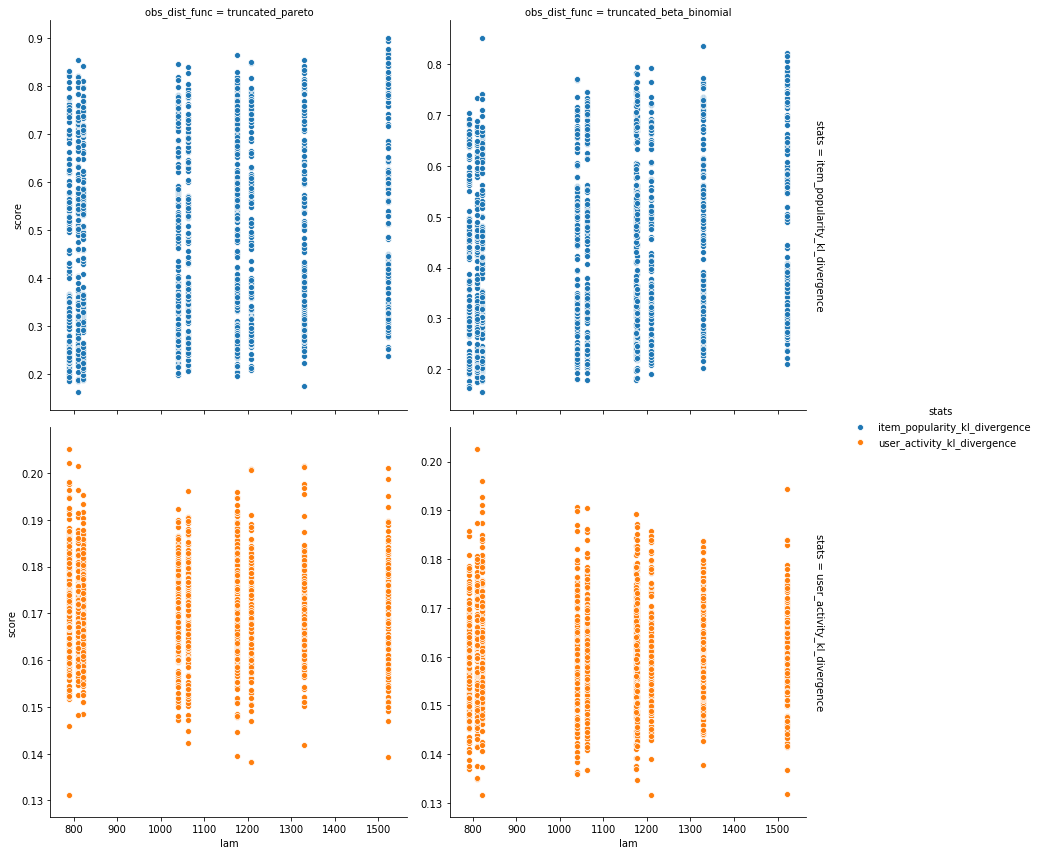

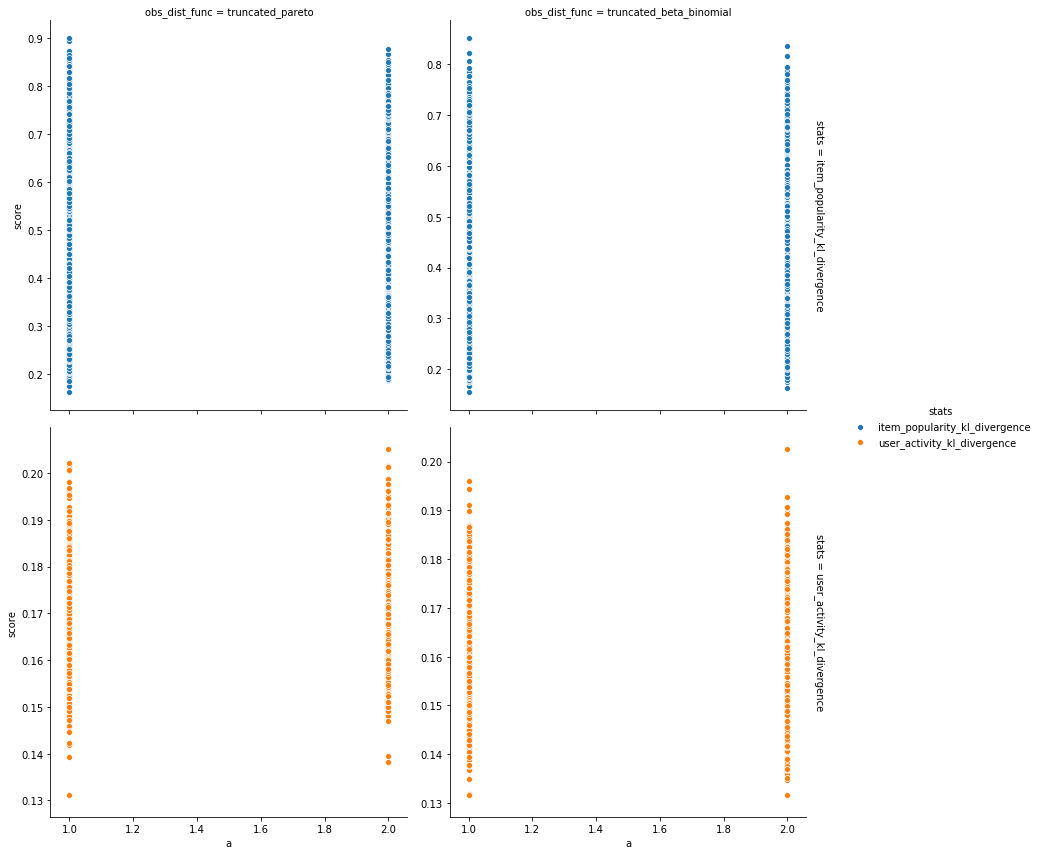

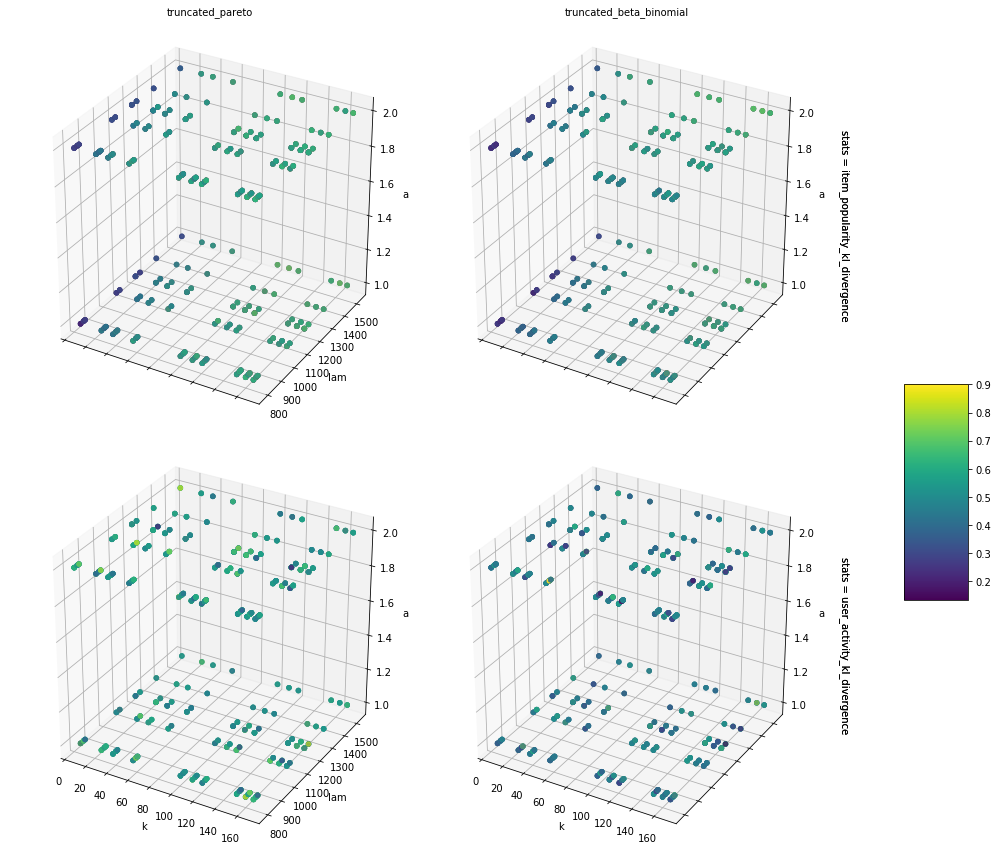

In [18]:
stats_vs_params(res_df, params=['obs_dist_func', 'pref_k', 'pref_lam', 'pref_a'])

Generate simulated data using the best parameters

In [21]:
def simulated_lda_bb(nusers=943, nitems=1682, k=8, lam=820.729662, a=1, b=1, c=1, d=2):
#     pref = generate_ibp_df(943, 1009.2, 0.3, 0.8)
    pref = generate_lda(nusers, nitems, k, lam, a, b, c, d)
    obs = sample_popular_n(pref, truncated_beta_binomial, True, a=1.6638872003071793e-05, b=2.8157887296158077, n=737)
    return obs

In [22]:
def simulated_lda_pareto(nusers=943, nitems=1682, k=8, lam=810.214904, a=1, b=2, c=1, d=2):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = pref = generate_lda(nusers, nitems, k, lam, a, b, c, d)
    obs = sample_popular_n(pref, truncated_pareto, True, m=20.00000045, alpha=0.510528)
    return obs

In [23]:
def simulated_ibp_bb(nusers=943, alpha=766.416914, c=0.706652, sigma=0.010184):
#     pref = generate_ibp_df(943, 1009.2, 0.3, 0.8)
    pref = generate_ibp_itemwise(nusers, alpha, c, sigma)
    obs = sample_popular_n(pref, truncated_beta_binomial, True, a=1.6638872003071793e-05, b=2.8157887296158077, n=737)
    return obs

In [24]:
def simulated_ibp_pareto(nusers=943, alpha=799.486970, c=0.910087, sigma=0):
#     pref = generate_ibp_df(943, 1009.2, 10, 0)
    pref = generate_ibp_itemwise(nusers, alpha, c, sigma)
    obs = sample_popular_n(pref, truncated_pareto, True, m=20.00000045, alpha=0.510528)
    return obs

In [25]:
data['rating'] = 1

/home/MucunTian/anaconda3/envs/eval-err/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


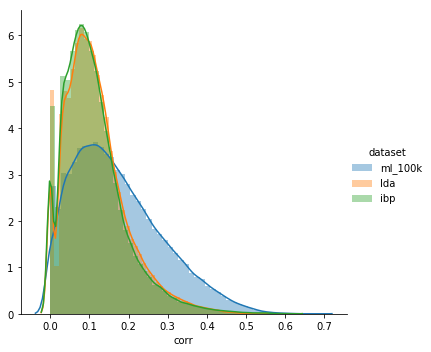

In [26]:
ml_dcorr = compute_cosine_corr(data, _sample_pairs)
simulated_lda = simulated_lda_bb()
simulated_lda['rating'] = 1
lda_dcorr = compute_cosine_corr(simulated_lda, _sample_pairs)

simulated_ibp = simulated_ibp_bb()
simulated_ibp['rating'] = 1
ibp_dcorr = compute_cosine_corr(simulated_ibp, _sample_pairs)

data2plot = pd.concat([pd.DataFrame({'dataset': 'ml_100k', 'corr': ml_dcorr}),
                       pd.DataFrame({'dataset': 'lda', 'corr': lda_dcorr}), 
                       pd.DataFrame({'dataset': 'ibp', 'corr': ibp_dcorr})], ignore_index=True)

g = sns.FacetGrid(data2plot, hue='dataset', height=5)
g = g.map(sns.distplot, 'corr').add_legend()

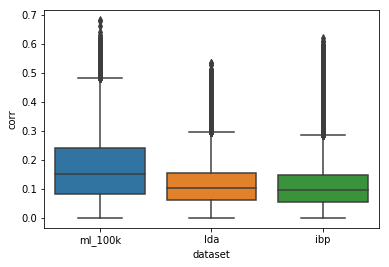

In [28]:
sns.boxplot(x="dataset", y="corr", data=data2plot)

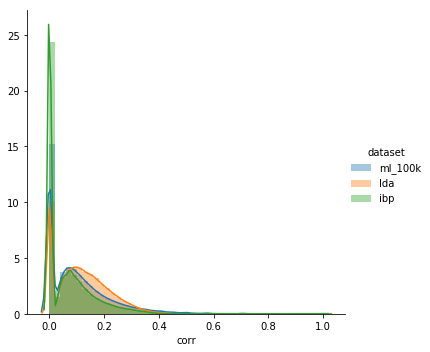

In [29]:
ml_dcorr = compute_cosine_corr(data, _sample_pairs, 'item', 'user')
simulated_lda = simulated_lda_bb()
simulated_lda['rating'] = 1
lda_dcorr = compute_cosine_corr(simulated_lda, _sample_pairs, 'item', 'user')
simulated_ibp = simulated_ibp_bb()
simulated_ibp['rating'] = 1
ibp_dcorr = compute_cosine_corr(simulated_ibp, _sample_pairs, 'item', 'user')

data2plot = pd.concat([pd.DataFrame({'dataset': 'ml_100k', 'corr': ml_dcorr}),
                       pd.DataFrame({'dataset': 'lda', 'corr': lda_dcorr}), 
                       pd.DataFrame({'dataset': 'ibp', 'corr': ibp_dcorr})], ignore_index=True)

g = sns.FacetGrid(data2plot, hue='dataset', height=5)
g = g.map(sns.distplot, 'corr').add_legend()

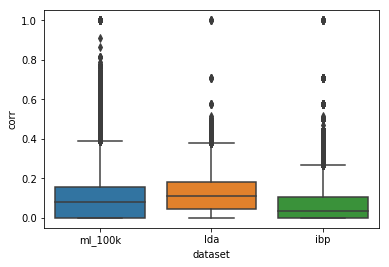

In [30]:
sns.boxplot(x="dataset", y="corr", data=data2plot)

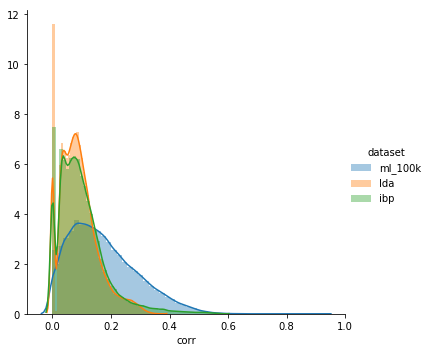

In [54]:
ml_dcorr = compute_cosine_corr(data, _sample_pairs)
simulated_lda = simulated_lda_pareto()
simulated_lda['rating'] = 1
lda_dcorr = compute_cosine_corr(simulated_lda, _sample_pairs)

simulated_ibp = simulated_ibp_pareto()
simulated_ibp['rating'] = 1
ibp_dcorr = compute_cosine_corr(simulated_ibp, _sample_pairs)

data2plot = pd.concat([pd.DataFrame({'dataset': 'ml_100k', 'corr': ml_dcorr}),
                       pd.DataFrame({'dataset': 'lda', 'corr': lda_dcorr}), 
                       pd.DataFrame({'dataset': 'ibp', 'corr': ibp_dcorr})], ignore_index=True)

g = sns.FacetGrid(data2plot, hue='dataset', height=5)
g = g.map(sns.distplot, 'corr').add_legend()

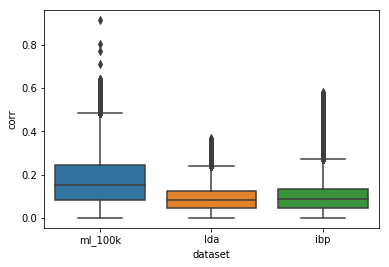

In [55]:
sns.boxplot(x="dataset", y="corr", data=data2plot)

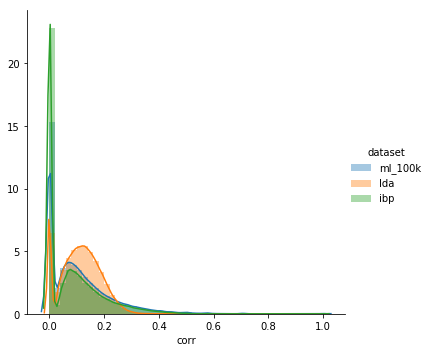

In [56]:
ml_dcorr = compute_cosine_corr(data, _sample_pairs, 'item', 'user')
simulated_lda = simulated_lda_pareto()
simulated_lda['rating'] = 1
lda_dcorr = compute_cosine_corr(simulated_lda, _sample_pairs, 'item', 'user')
simulated_ibp = simulated_ibp_pareto()
simulated_ibp['rating'] = 1
ibp_dcorr = compute_cosine_corr(simulated_ibp, _sample_pairs, 'item', 'user')

data2plot = pd.concat([pd.DataFrame({'dataset': 'ml_100k', 'corr': ml_dcorr}),
                       pd.DataFrame({'dataset': 'lda', 'corr': lda_dcorr}), 
                       pd.DataFrame({'dataset': 'ibp', 'corr': ibp_dcorr})], ignore_index=True)

g = sns.FacetGrid(data2plot, hue='dataset', height=5)
g = g.map(sns.distplot, 'corr').add_legend()

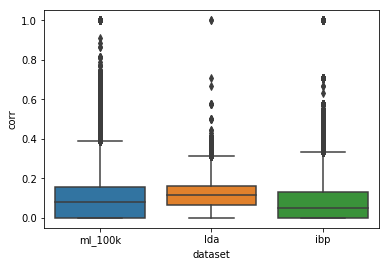

In [57]:
sns.boxplot(x="dataset", y="corr", data=data2plot)

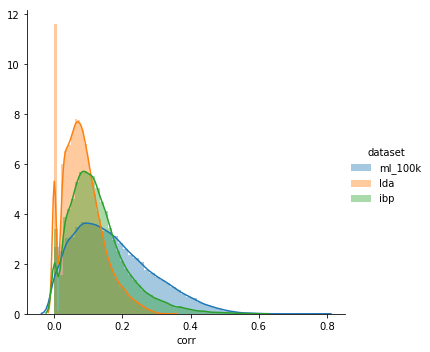

In [58]:
ml_dcorr = compute_cosine_corr(data, _sample_pairs)
simulated_lda = simulated_lda_bb(nusers=943, nitems=1682, k=35, lam=391.582513)
simulated_lda['rating'] = 1
lda_dcorr = compute_cosine_corr(simulated_lda, _sample_pairs)

simulated_ibp = simulated_ibp_bb(943, 766.416914, 0.706652, 0.010184)
simulated_ibp['rating'] = 1
ibp_dcorr = compute_cosine_corr(simulated_ibp, _sample_pairs)

data2plot = pd.concat([pd.DataFrame({'dataset': 'ml_100k', 'corr': ml_dcorr}),
                       pd.DataFrame({'dataset': 'lda', 'corr': lda_dcorr}), 
                       pd.DataFrame({'dataset': 'ibp', 'corr': ibp_dcorr})], ignore_index=True)

g = sns.FacetGrid(data2plot, hue='dataset', height=5)
g = g.map(sns.distplot, 'corr').add_legend()

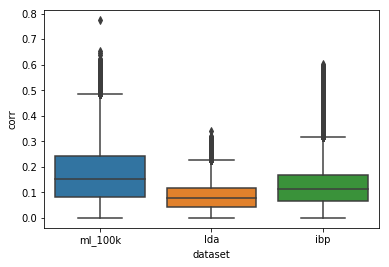

In [59]:
sns.boxplot(x="dataset", y="corr", data=data2plot)

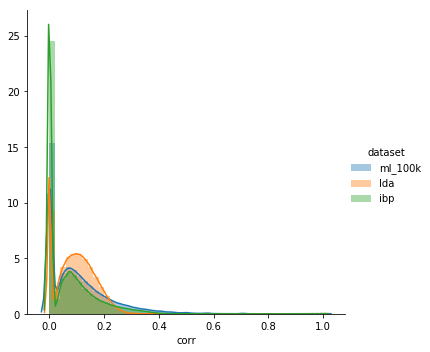

In [60]:
ml_dcorr = compute_cosine_corr(data, _sample_pairs, 'item', 'user')
simulated_lda = simulated_lda_bb(nusers=943, nitems=1682, k=35, lam=391.582513)
simulated_lda['rating'] = 1
lda_dcorr = compute_cosine_corr(simulated_lda, _sample_pairs, 'item', 'user')

simulated_ibp = simulated_ibp_bb(943, 766.416914, 0.706652, 0.010184)
simulated_ibp['rating'] = 1
ibp_dcorr = compute_cosine_corr(simulated_ibp, _sample_pairs, 'item', 'user')

data2plot = pd.concat([pd.DataFrame({'dataset': 'ml_100k', 'corr': ml_dcorr}),
                       pd.DataFrame({'dataset': 'lda', 'corr': lda_dcorr}), 
                       pd.DataFrame({'dataset': 'ibp', 'corr': ibp_dcorr})], ignore_index=True)

g = sns.FacetGrid(data2plot, hue='dataset', height=5)
g = g.map(sns.distplot, 'corr').add_legend()

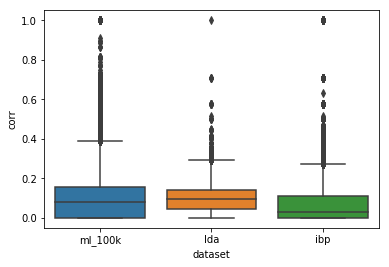

In [61]:
sns.boxplot(x="dataset", y="corr", data=data2plot)

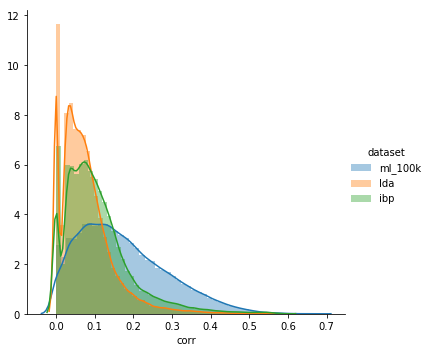

In [62]:
ml_dcorr = compute_cosine_corr(data, _sample_pairs)
simulated_lda = simulated_lda_pareto(943, 1682, 37, 1237.832802)
simulated_lda['rating'] = 1
lda_dcorr = compute_cosine_corr(simulated_lda, _sample_pairs)

simulated_ibp = simulated_ibp_pareto(943, 799.486970, 0.910087, 0.000000)
simulated_ibp['rating'] = 1
ibp_dcorr = compute_cosine_corr(simulated_ibp, _sample_pairs)

data2plot = pd.concat([pd.DataFrame({'dataset': 'ml_100k', 'corr': ml_dcorr}),
                       pd.DataFrame({'dataset': 'lda', 'corr': lda_dcorr}), 
                       pd.DataFrame({'dataset': 'ibp', 'corr': ibp_dcorr})], ignore_index=True)

g = sns.FacetGrid(data2plot, hue='dataset', height=5)
g = g.map(sns.distplot, 'corr').add_legend()

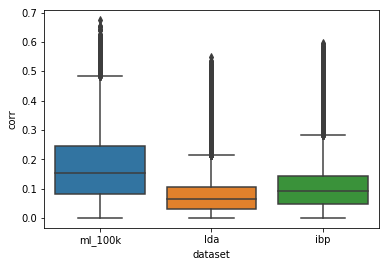

In [63]:
sns.boxplot(x="dataset", y="corr", data=data2plot)

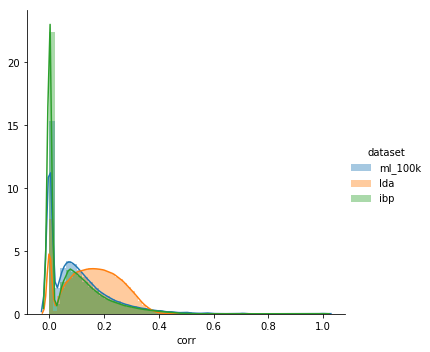

In [64]:
ml_dcorr = compute_cosine_corr(data, _sample_pairs, 'item', 'user')
simulated_lda = simulated_lda_pareto(943, 1682, 37, 1237.832802)
simulated_lda['rating'] = 1
lda_dcorr = compute_cosine_corr(simulated_lda, _sample_pairs, 'item', 'user')

simulated_ibp = simulated_ibp_pareto(943, 799.486970, 0.910087, 0.000000)
simulated_ibp['rating'] = 1
ibp_dcorr = compute_cosine_corr(simulated_ibp, _sample_pairs, 'item', 'user')

data2plot = pd.concat([pd.DataFrame({'dataset': 'ml_100k', 'corr': ml_dcorr}),
                       pd.DataFrame({'dataset': 'lda', 'corr': lda_dcorr}), 
                       pd.DataFrame({'dataset': 'ibp', 'corr': ibp_dcorr})], ignore_index=True)

g = sns.FacetGrid(data2plot, hue='dataset', height=5)
g = g.map(sns.distplot, 'corr').add_legend()

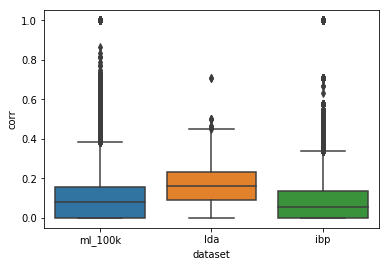

In [65]:
sns.boxplot(x="dataset", y="corr", data=data2plot)

In [31]:
def simulated_data(name, *args, **kwargs):
    out = None
    if 'TBB' in name:
        out = simulated_lda_bb(*args, **kwargs)
    if 'TP' in name:
        out = simulated_lda_pareto(*args, **kwargs)
    return out

In [32]:
# def simulated_data_geo():
#     pref = generate_ibp_df(943, 1009, 1, 0)
#     obs = sample_popular_n(pref, np.random.geometric, False, p=0.05)
#     return obs

In [33]:
def compute_density(data):
    nusers = len(data['user'].unique())
    nitems = len(data['item'].unique())
    npairs = len(data)
    density = npairs / nitems / nusers
    return nusers, nitems, npairs, density

In [34]:
def compute_data_stats(data):
    pairs = data.loc[:, ['user', 'item']]
    user_activity = pairs.groupby('user', as_index=False).count().rename(columns={'item': 'count'})
    item_popularity = pairs.groupby('item', as_index=False).count().rename(columns={'user': 'count'})
    return user_activity, item_popularity

In [35]:
def summarize_dataset(name, data_func, *args, **kwargs):
    dataset = data_func(*args, **kwargs)
    colname = dataset.columns
    if not {'user', 'item'}.issubset(colname):
        dataset.rename(columns={colname[0]: 'user',
                                colname[1]: 'item'},
                       inplace=True)
    dataset = dataset[['user', 'item']]
    data_meta = compute_density(dataset)
    data_meta_stats = tuple([name, *data_meta])
    
    user_activity, item_popularity = compute_data_stats(dataset)
    user_activity['dataset'] = name
    user_activity.drop('user', axis=1, inplace=True)
    item_popularity['dataset'] = name
    item_popularity.drop('item', axis=1, inplace=True)
    item_popularity['rank'] = item_popularity['count'].rank(method='min', ascending=False)

    user_activity_stats = user_activity['count'].rename(name).describe()
    item_popularity_stats = item_popularity['count'].rename(name).describe()
    return data_meta_stats, user_activity_stats, item_popularity_stats, user_activity, item_popularity

In [41]:
def summarize_datasets(params, pref_params):
    from multiprocessing import Pool
    from itertools import repeat
    params = params.join(params.groupby('obs_dist_func').cumcount().rename('param_no'))
    params['name'] = params['obs_dist_func'].map(lambda x: ''.join(next(zip(*x.split('_')))).upper()) + params['param_no'].map(str)
    params = zip(params['name'].values, repeat(simulated_data), 
                 *params[['name', *pref_params]].to_dict('list').values()) 
    with Pool(10) as p:
        results = p.starmap(summarize_dataset, params)
    simulated_results = zip(*results)
    ml_100k_results = summarize_dataset('ml_100k', ml_100k)
    df = pd.DataFrame.from_records([ml_100k_results[0], *next(simulated_results)],
                               columns=['dataset', 'nusers', 'nitems', 'npairs', 'density'])
    print('dataset stats')
    print(df)

    df = pd.concat([ml_100k_results[1], *next(simulated_results)], axis=1)
    print('user profile stats')
    print(df)

    df = pd.concat([ml_100k_results[2], *next(simulated_results)], axis=1)
    print('item popularity stats')
    print(df)

    user_profile_df = pd.concat(next(simulated_results), axis=0, ignore_index=True)

    item_popularity_df = pd.concat(next(simulated_results), axis=0, ignore_index=True)
    return ml_100k_results[3:], user_profile_df, item_popularity_df

In [38]:
def plot_scatter_against_baseline(*args, **kwargs):
    data = pd.concat(args, axis=1)
    data['dataset'] = kwargs.get('label')
    base = kwargs.pop('baseline')
    data = data.append(base[data.columns], ignore_index=True)
    args = map(lambda x: x.name, args)
    kwargs['label'] = data['dataset'].unique()
    ax = sns.scatterplot(*args, data=data, **kwargs)
    return ax

In [39]:
def plot_stats(result, params=['pref_nusers', 'pref_alpha', 'pref_c', 'pref_sigma'], nparams=10):
    result['distance'] = result['item_popularity_kl_divergence'] ** 2 + result['user_activity_kl_divergence'] ** 2
    res_params = result[[*params, 'obs_dist_func', 'item_popularity_kl_divergence', 'user_activity_kl_divergence', 'distance']]
    NPARAMS = nparams
    for metric in ('item_popularity_kl_divergence', 'user_activity_kl_divergence', 'distance'):
        sub_params = res_params.sort_values(['obs_dist_func', metric]).groupby('obs_dist_func').head(NPARAMS)
        print(f'\033[1m Top {nparams} parameters sorted by {metric}\033[0m')
        ml_100k_results, user_profile_df, item_popularity_df = summarize_datasets(sub_params, params)
        g = sns.FacetGrid(item_popularity_df, col='dataset', hue='dataset', sharex=False, sharey=False, col_wrap=5, height=5)
        g = (g.map(plot_scatter_against_baseline, 'rank', 'count', hue='dataset', alpha=0.5, baseline=ml_100k_results[1])
             .set(xscale='log', yscale='log')
             .set_axis_labels('rank', 'popularity'))
        popularity_counts = (item_popularity_df[['dataset', 'count']].groupby(['dataset', 'count'])
                             .size().reset_index().rename(columns={'count': 'popularity', 0: 'count'}))
        ml_100k_pop_counts = (ml_100k_results[1][['dataset', 'count']].groupby(['dataset', 'count'])
                              .size().reset_index().rename(columns={'count': 'popularity', 0: 'count'}))
        g = sns.FacetGrid(popularity_counts, col='dataset', hue='dataset', sharex=False, sharey=False, col_wrap=5, height=5)
        g = (g.map(plot_scatter_against_baseline, 'popularity', 'count', hue='dataset', alpha=0.5, baseline=ml_100k_pop_counts)
             .set(xscale='log', yscale='log'))
        plt.show()

 Top 10 parameters sorted by item_popularity_kl_divergence
dataset stats
    dataset  nusers  nitems  npairs   density
0   ml_100k     943    1682  100000  0.063047
1      TBB0     943    1441   98234  0.072291
2      TBB1     943    1458  102403  0.074481
3      TBB2     943    1464  104427  0.075641
4      TBB3     943    1418  101865  0.076179
5      TBB4     943    1452  100417  0.073338
6      TBB5     943    1429  101177  0.075082
7      TBB6     943    1523  101643  0.070773
8      TBB7     943    1467   99069  0.071614
9      TBB8     943    1452  101526  0.074148
10     TBB9     943    1459   99397  0.072245
11      TP0     943    1531  112642  0.078021
12      TP1     943    1483  114528  0.081895
13      TP2     943    1486  104455  0.074542
14      TP3     943    1564  102664  0.069610
15      TP4     943    1499  109267  0.077299
16      TP5     943    1505  107790  0.075950
17      TP6     943    1498  105954  0.075006
18      TP7     943    1517  109409  0.076481
19     

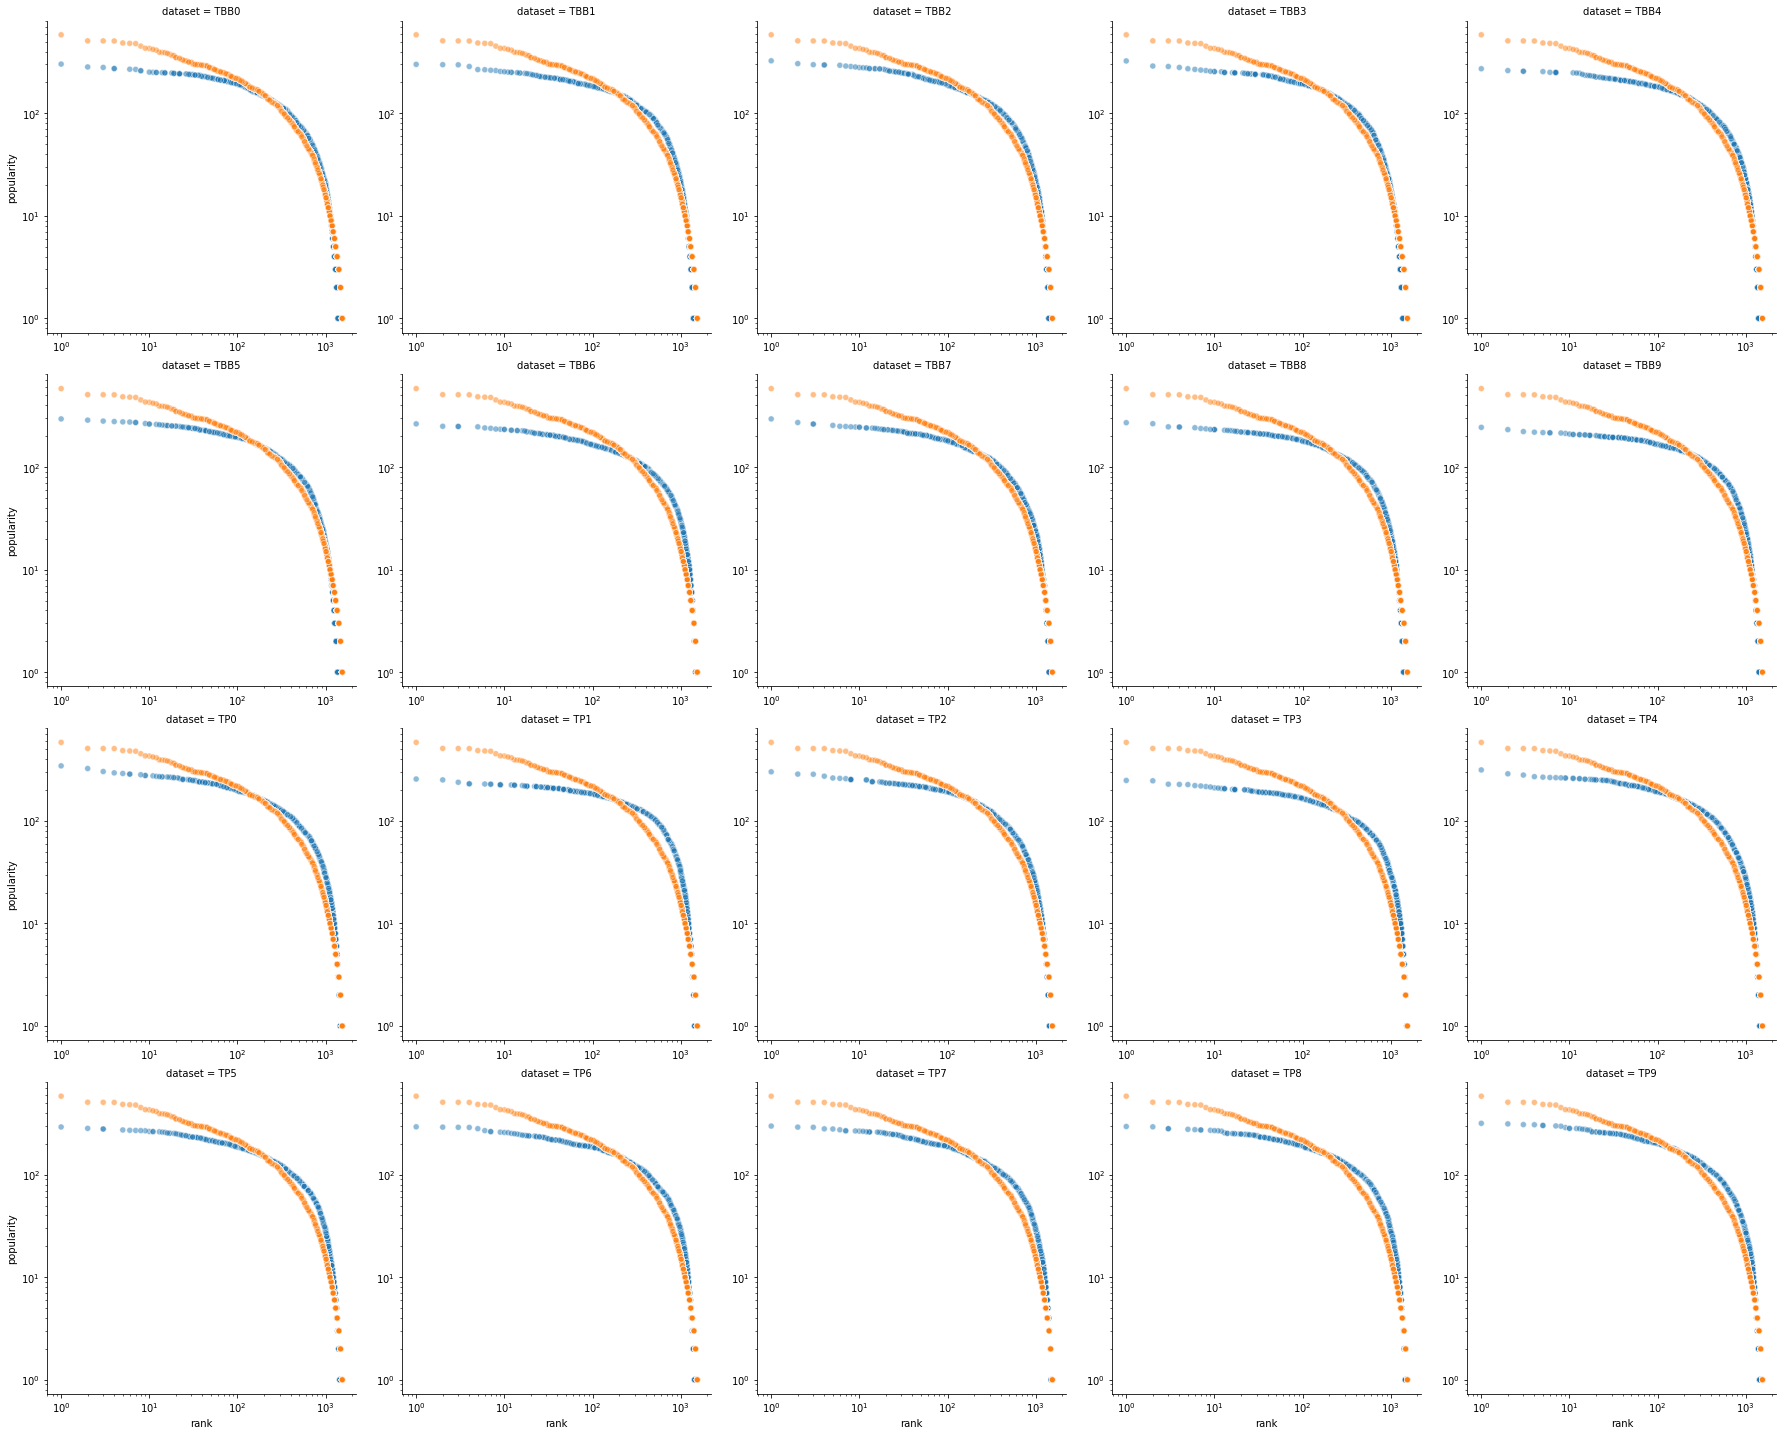

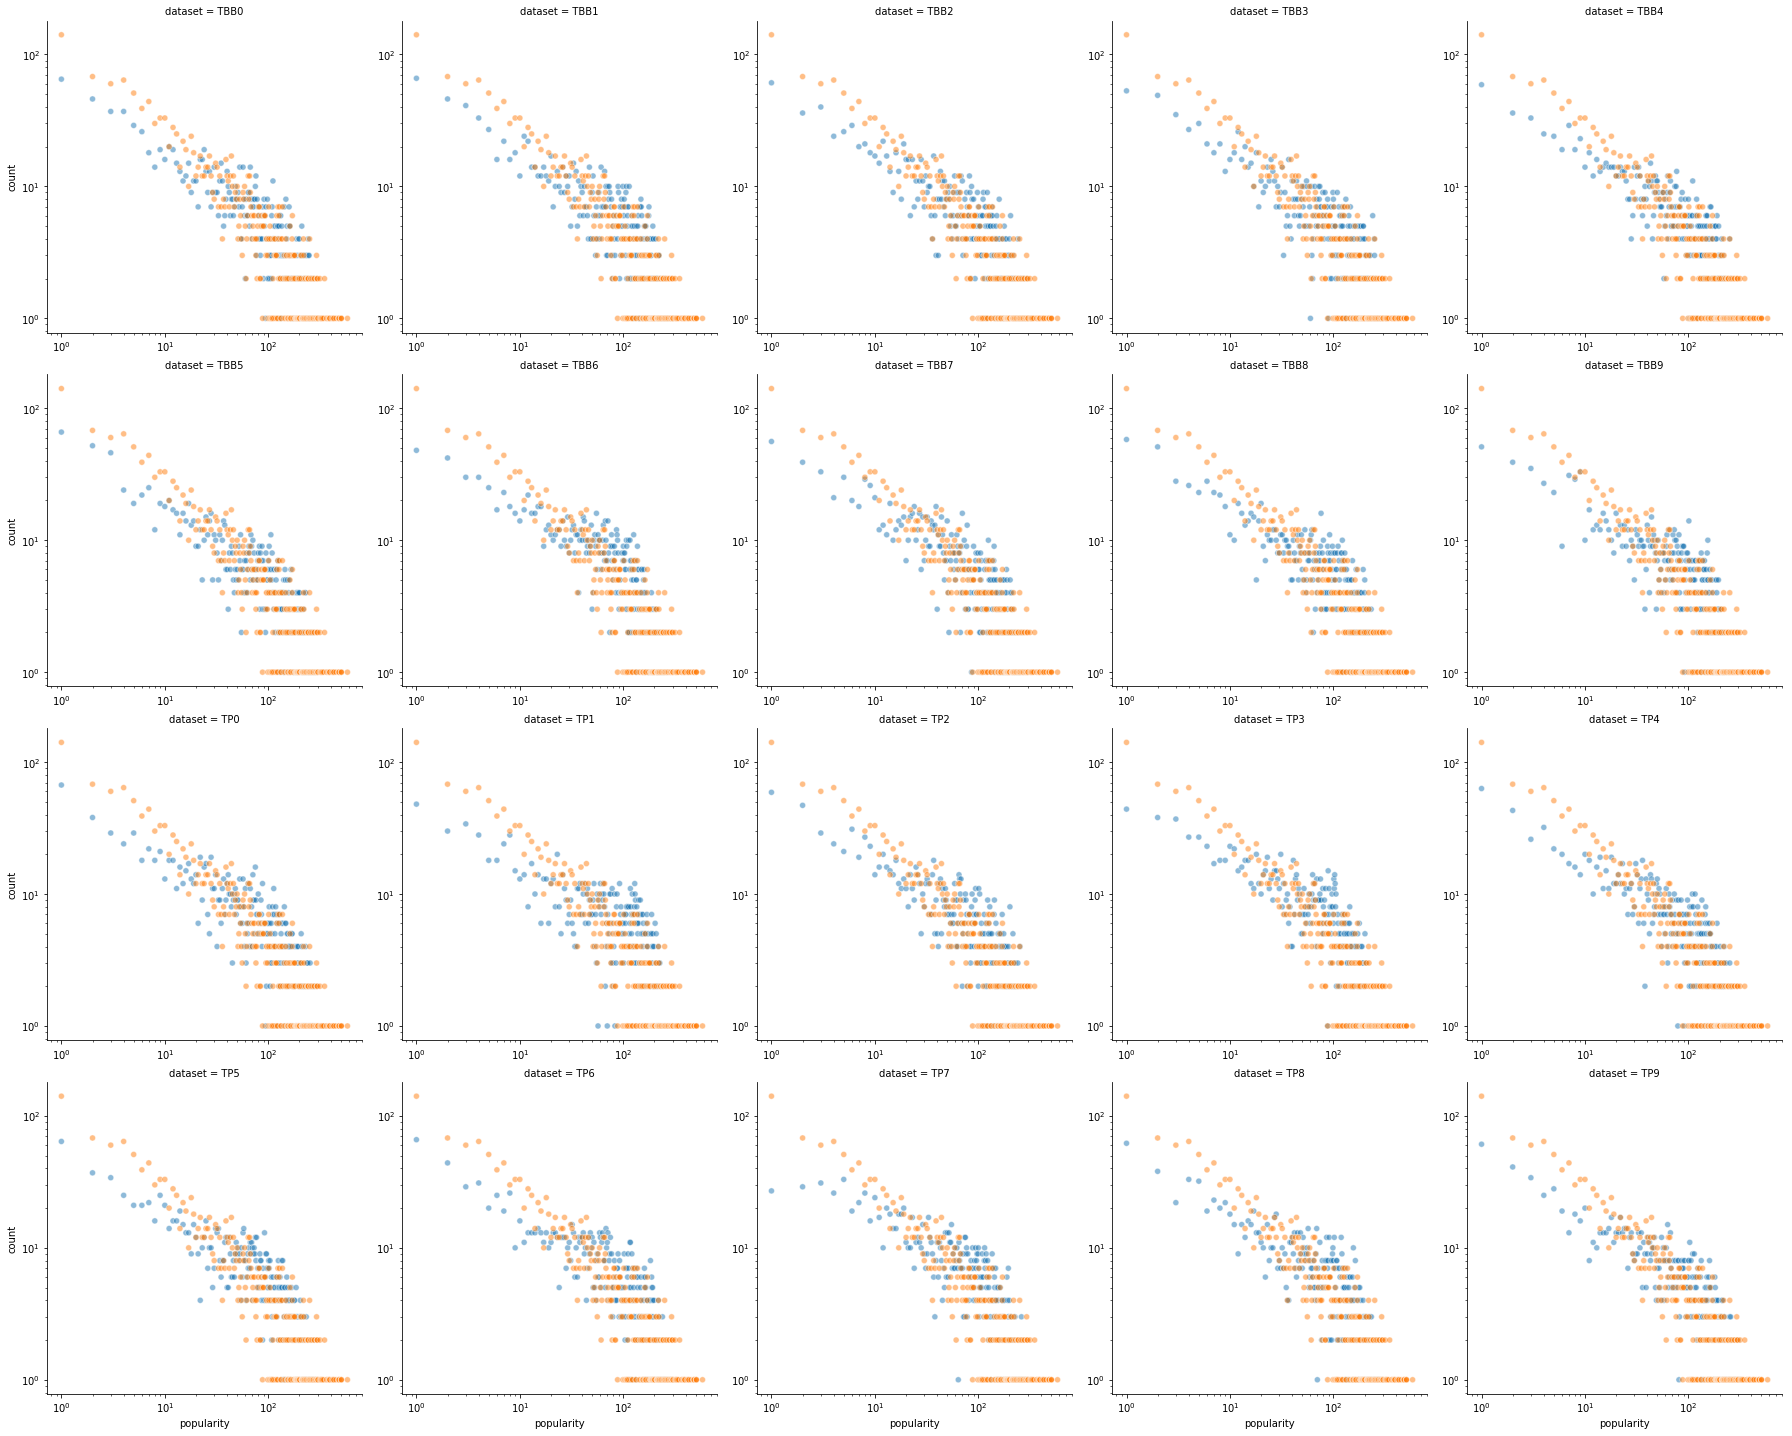

 Top 10 parameters sorted by user_activity_kl_divergence
dataset stats
    dataset  nusers  nitems  npairs   density
0   ml_100k     943    1682  100000  0.063047
1      TBB0     943    1619   96861  0.063444
2      TBB1     943    1677  100242  0.063388
3      TBB2     943    1672   97227  0.061665
4      TBB3     943    1546   99192  0.068039
5      TBB4     943    1603   99531  0.065844
6      TBB5     943    1671   96550  0.061272
7      TBB6     943    1576  103392  0.069570
8      TBB7     943    1647   96776  0.062311
9      TBB8     943    1415   96106  0.072025
10     TBB9     943    1677   97130  0.061420
11      TP0     943    1655  109222  0.069984
12      TP1     943    1667  114733  0.072986
13      TP2     943    1671  106010  0.067276
14      TP3     943    1672  110830  0.070293
15      TP4     943    1669  116508  0.074027
16      TP5     943    1601  118799  0.078688
17      TP6     943    1673  105796  0.067060
18      TP7     943    1672  105536  0.066935
19      T

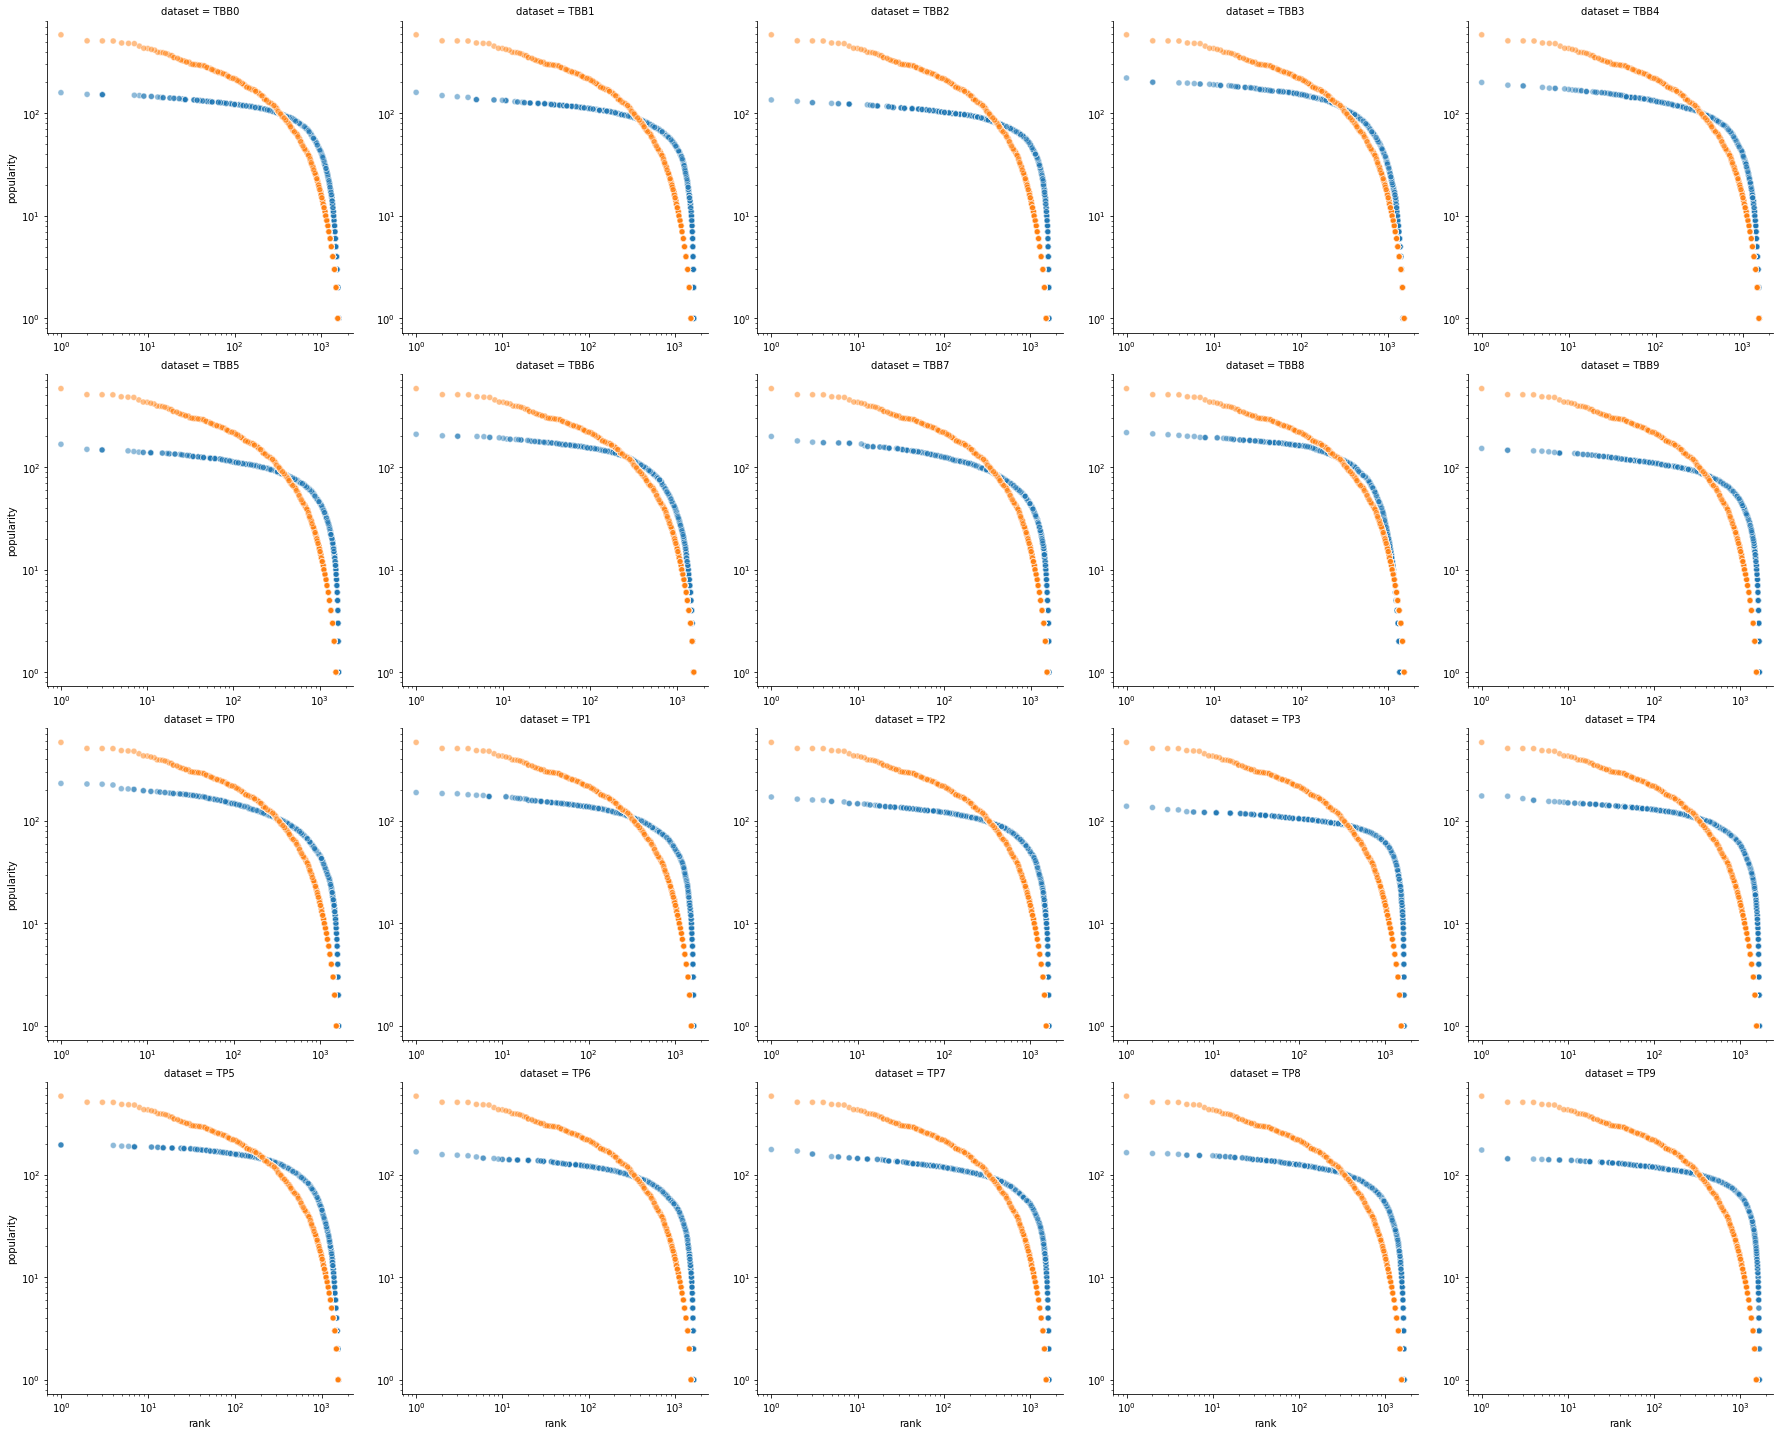

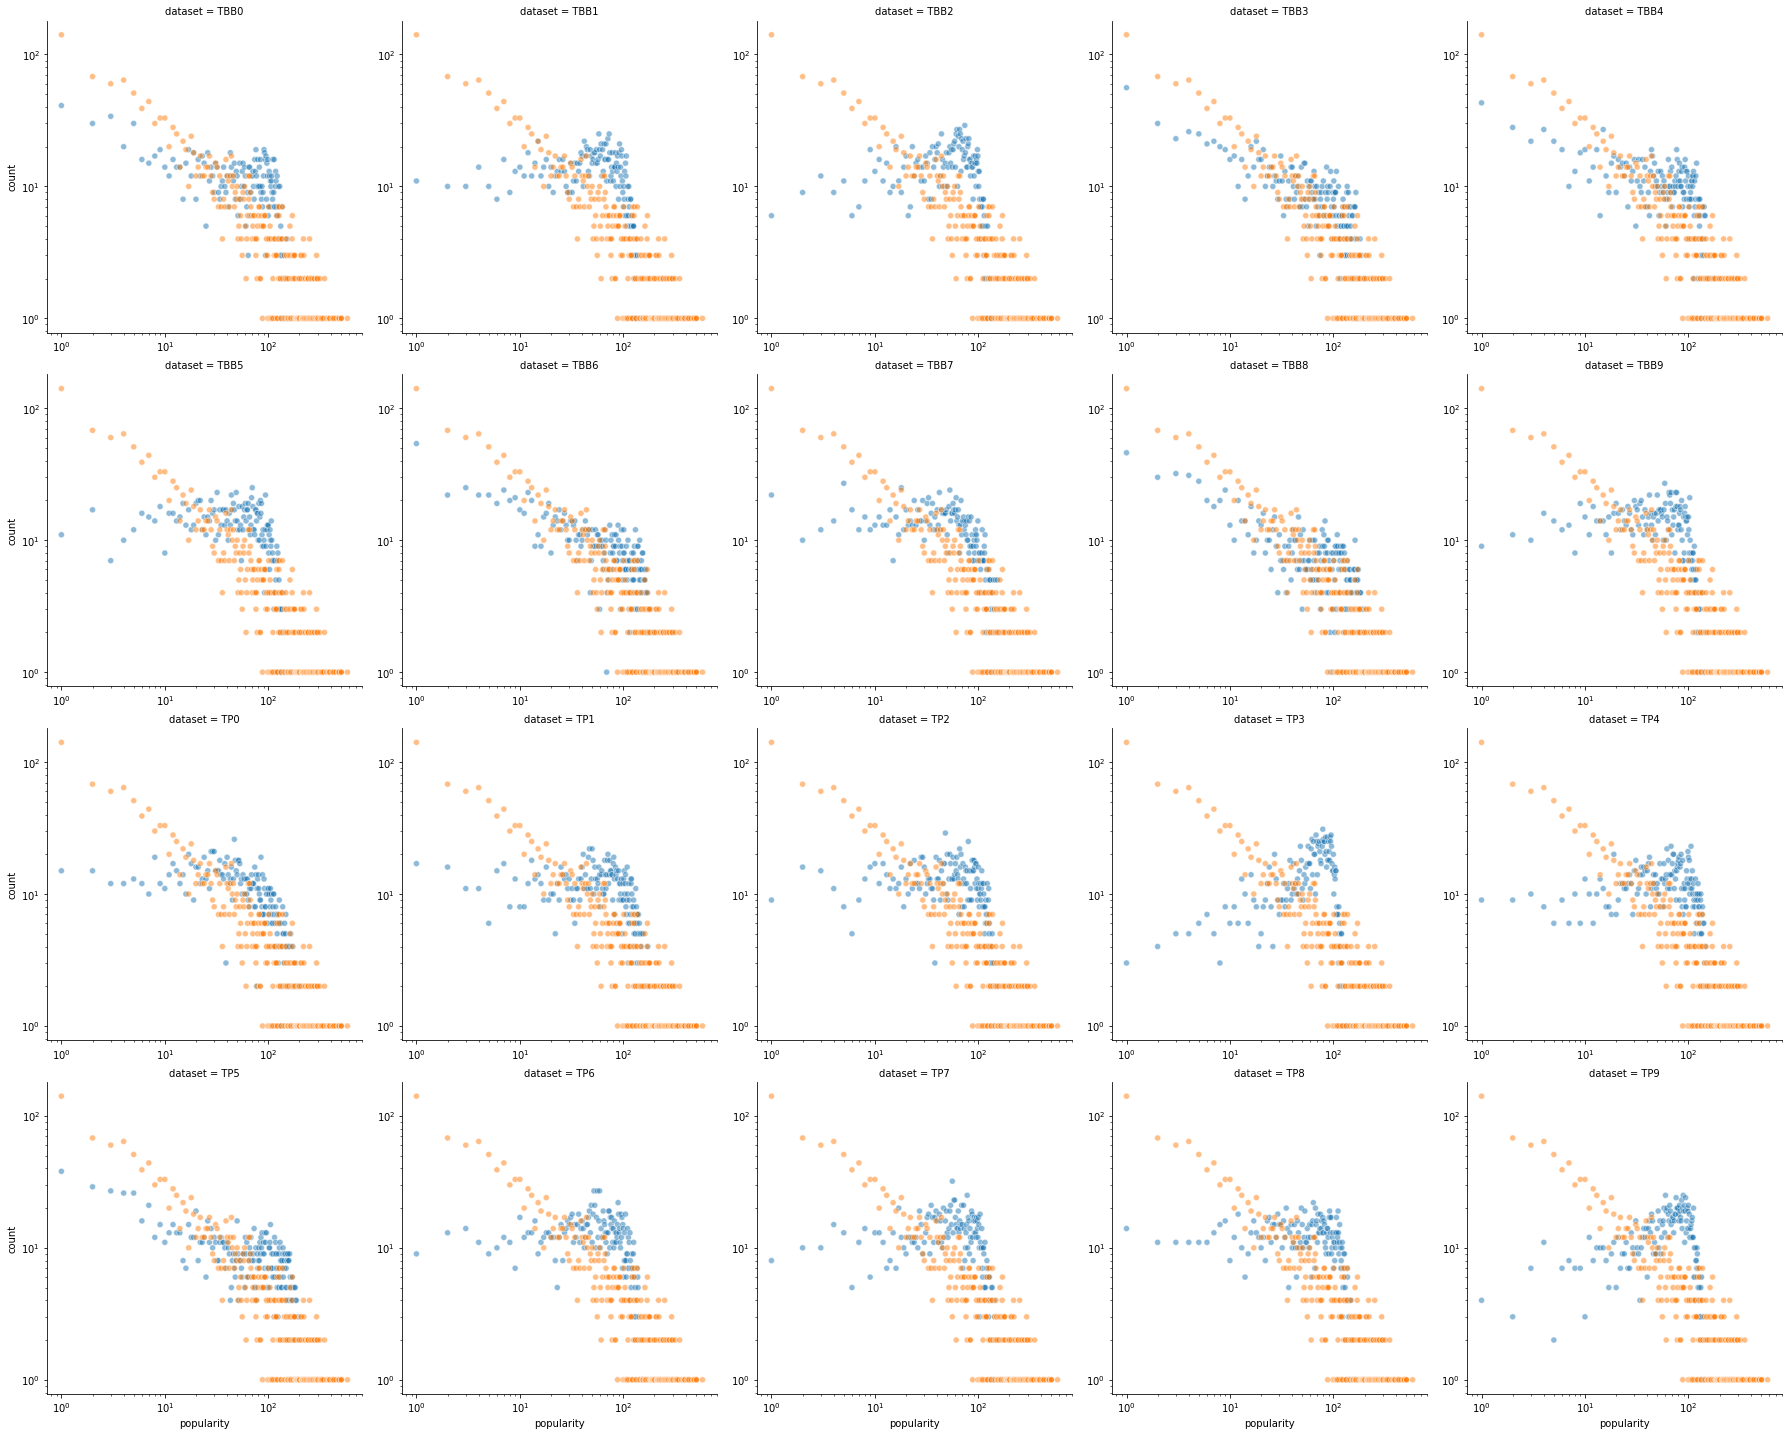

 Top 10 parameters sorted by distance
dataset stats
    dataset  nusers  nitems  npairs   density
0   ml_100k     943    1682  100000  0.063047
1      TBB0     943    1464  104427  0.075641
2      TBB1     943    1441   98234  0.072291
3      TBB2     943    1452  100417  0.073338
4      TBB3     943    1420  104115  0.077752
5      TBB4     943    1458  102403  0.074481
6      TBB5     943    1447   99135  0.072652
7      TBB6     943    1564   98982  0.067113
8      TBB7     943    1418  101865  0.076179
9      TBB8     943    1429  101177  0.075082
10     TBB9     943    1554  100763  0.068760
11      TP0     943    1483  114528  0.081895
12      TP1     943    1495  101055  0.071681
13      TP2     943    1466  107871  0.078030
14      TP3     943    1484  113851  0.081356
15      TP4     943    1565   93841  0.063587
16      TP5     943    1505  115710  0.081531
17      TP6     943    1586  109220  0.073028
18      TP7     943    1511  113400  0.079586
19      TP8     943    1506 

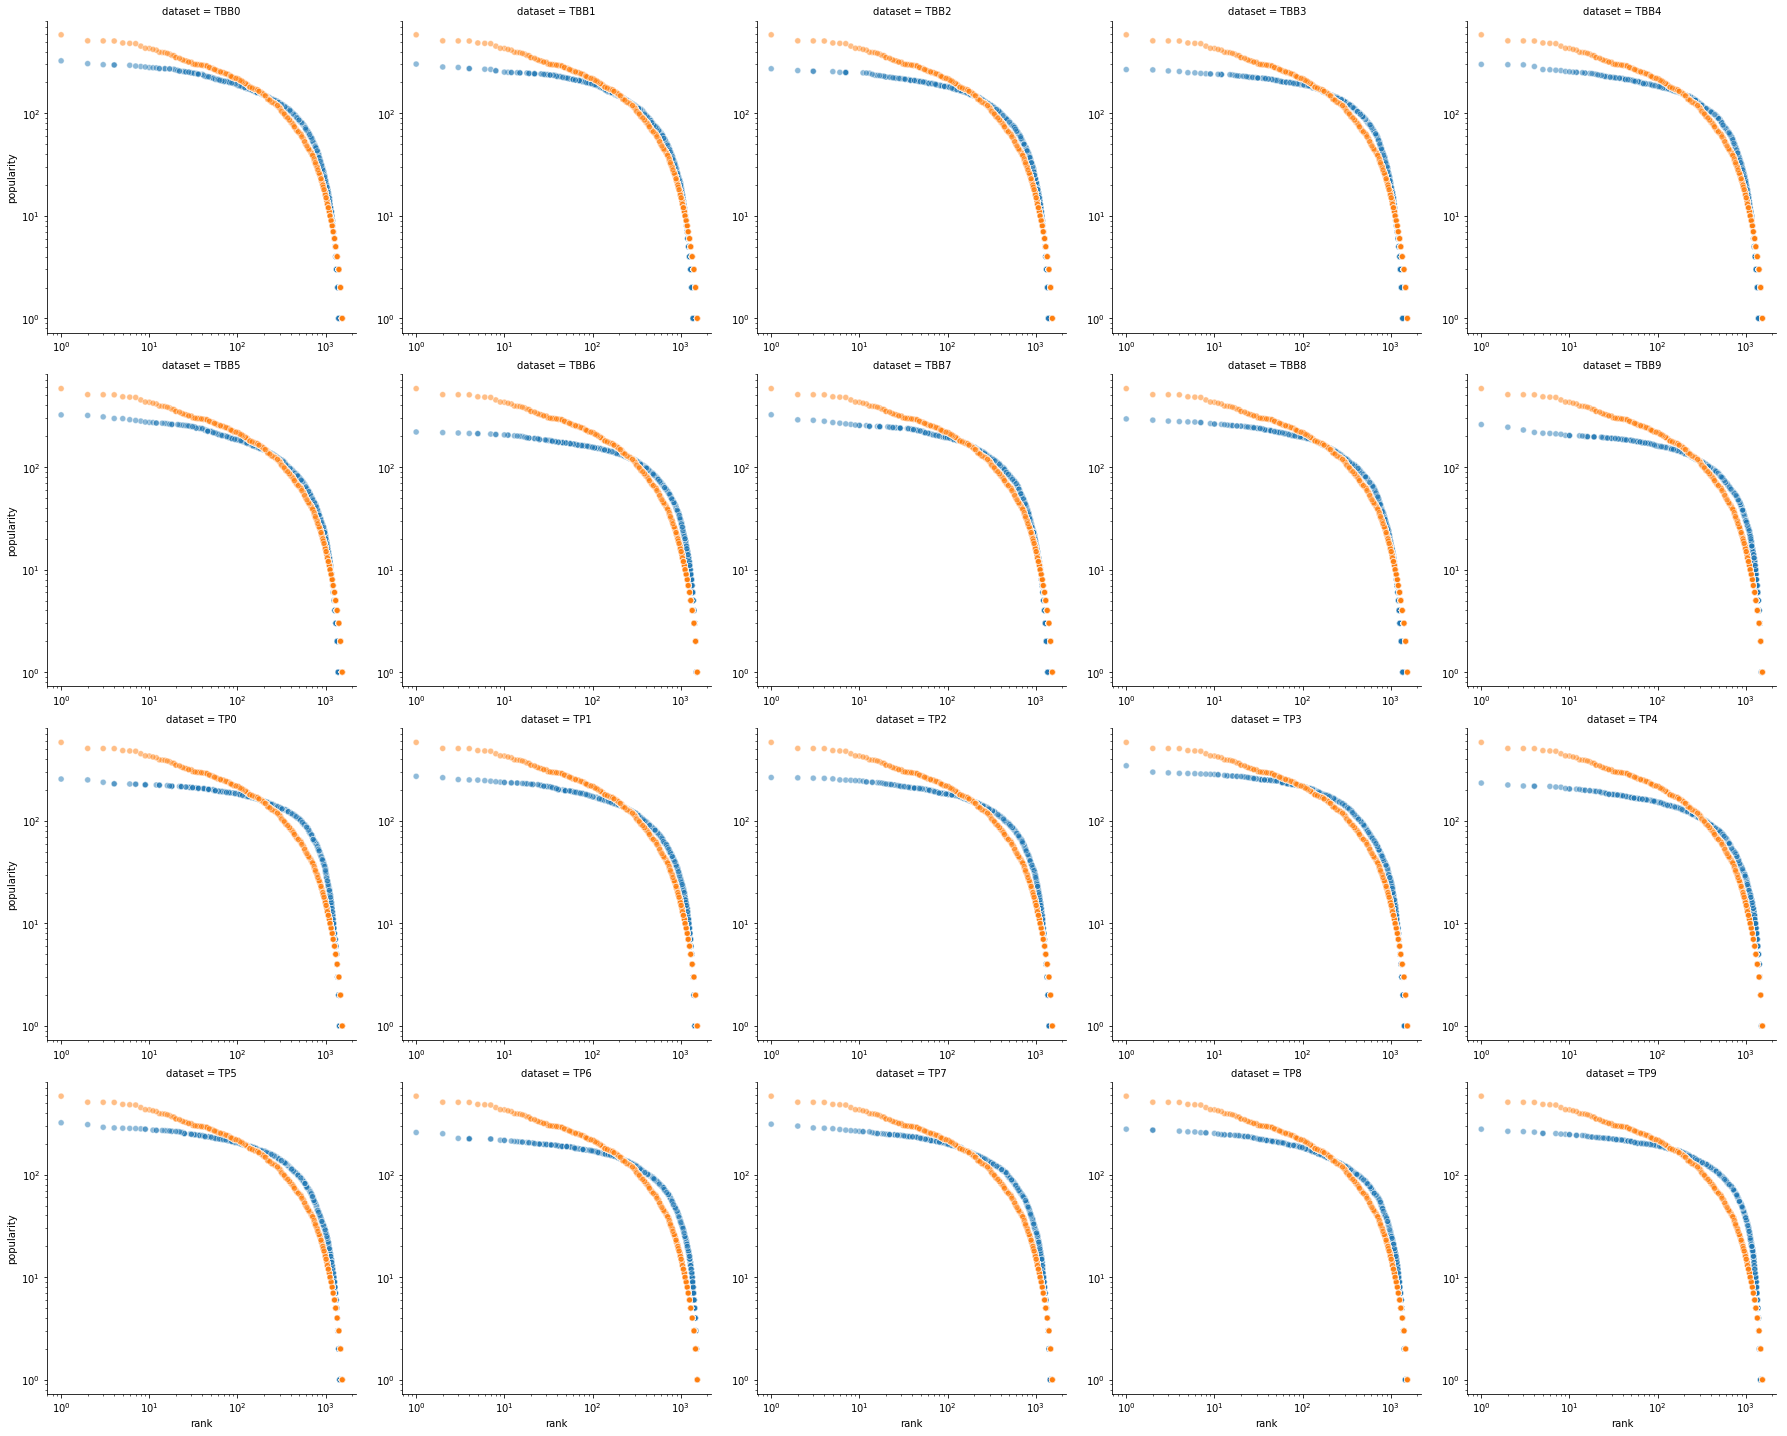

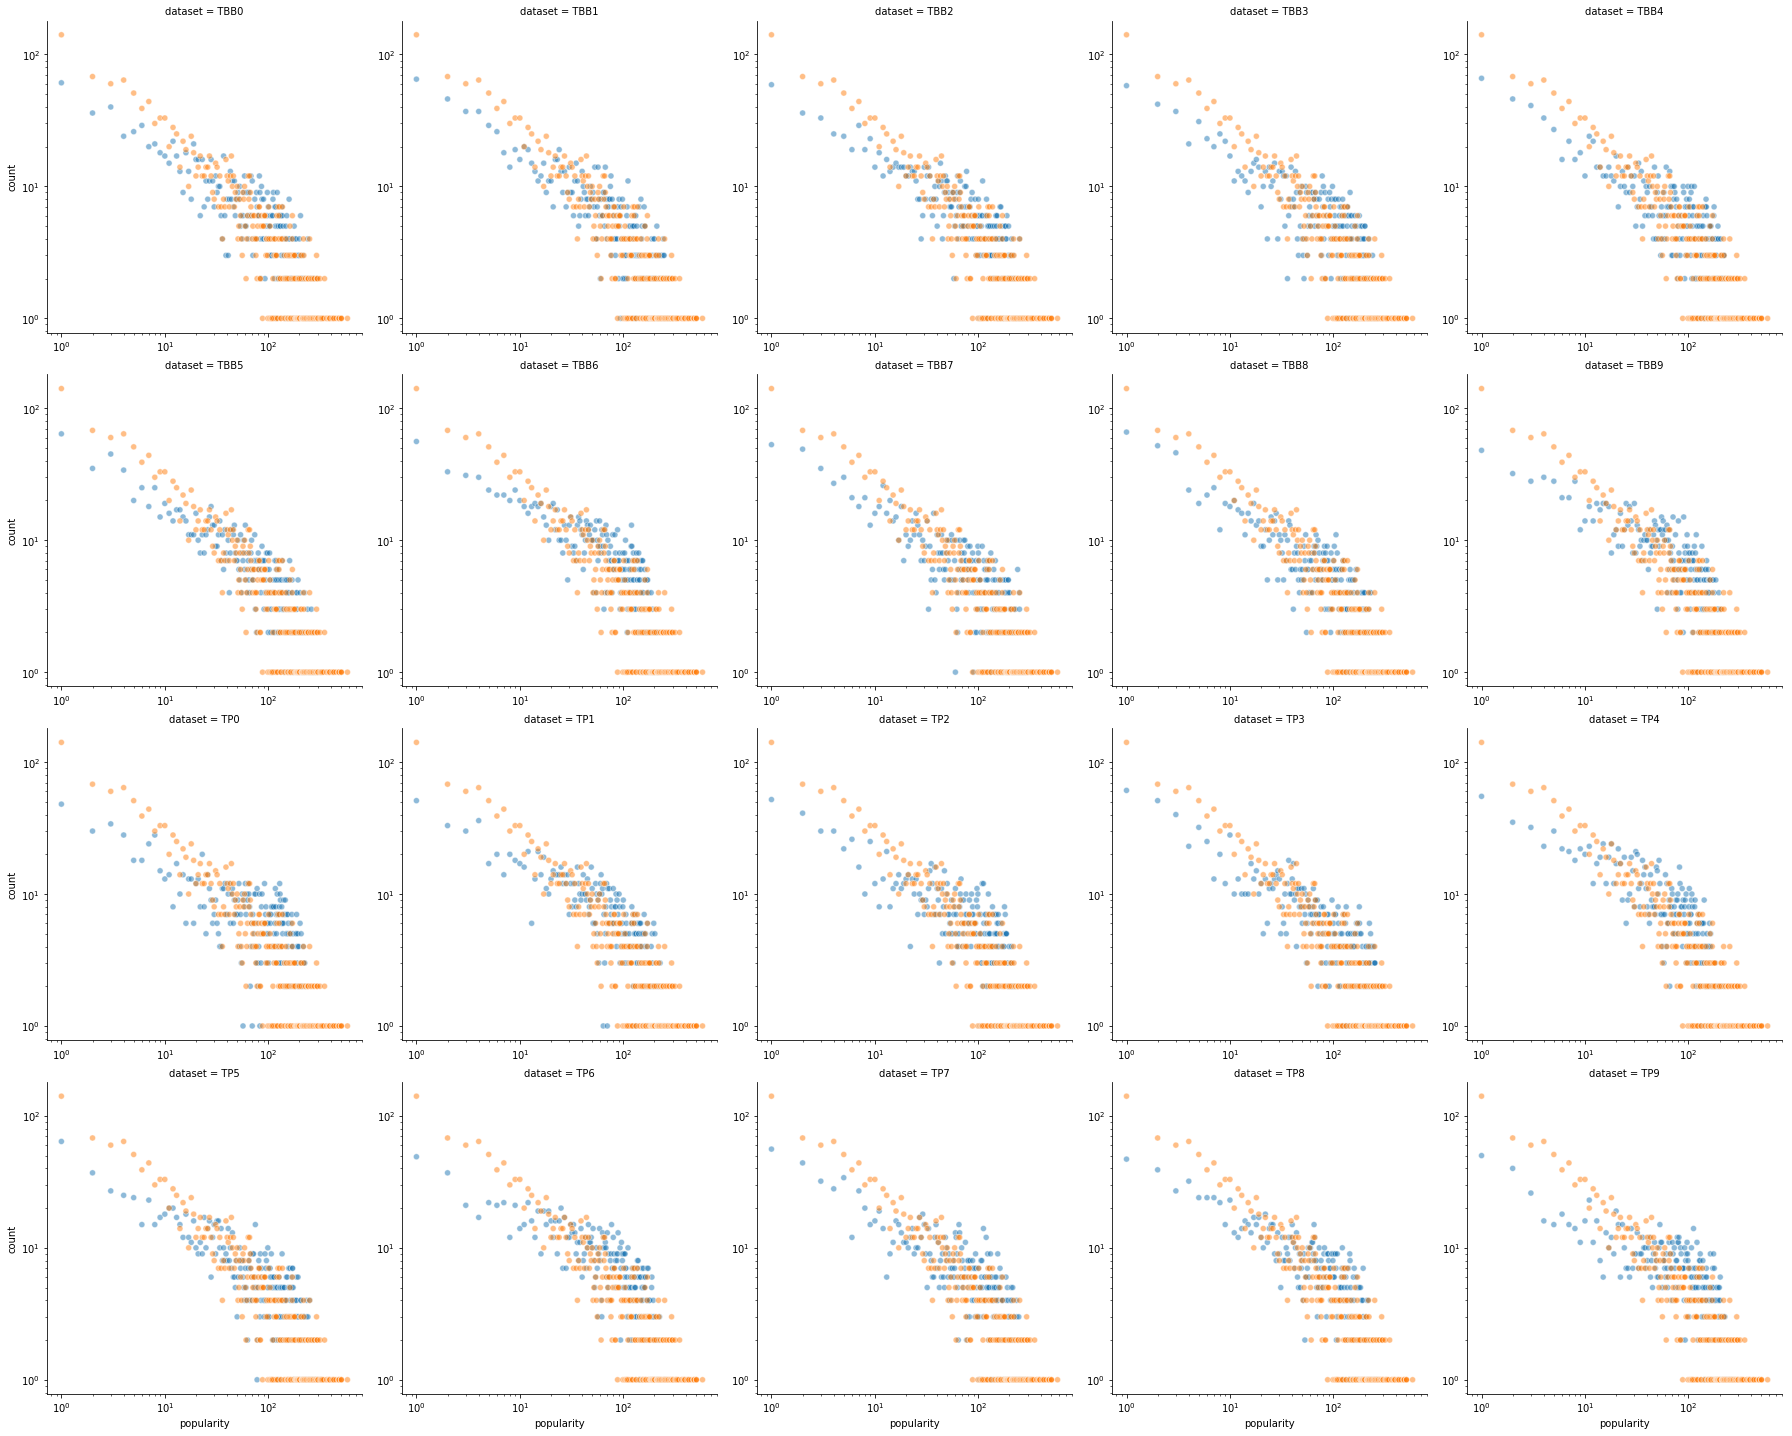

In [42]:
plot_stats(res_df, params=['pref_nusers', 'pref_nitems', 'pref_k', 'pref_lam', 'pref_a', 'pref_b', 'pref_c', 'pref_d'])

In [55]:
user_profile_model1 = user_profile_df[user_profile_df['dataset'].isin(['ml_100k', 'simulated_beta_binomail'])].copy()
user_profile_model1['group'] = 1
user_profile_model2 = user_profile_df[user_profile_df['dataset'].isin(['ml_100k', 'simulated_pareto'])].copy()
user_profile_model2['group'] = 2
user_profile_models = pd.concat([user_profile_model1, user_profile_model2])

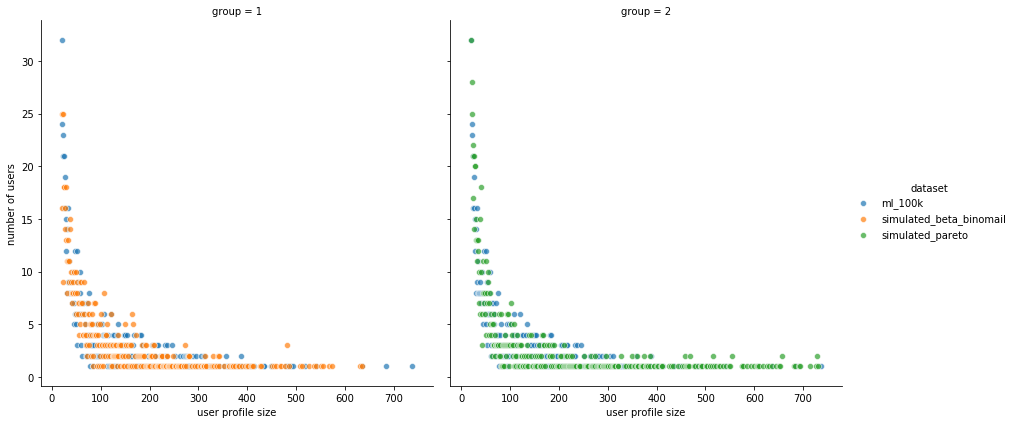

In [56]:
g = sns.FacetGrid(user_profile_models.groupby(['group', 'dataset', 'item'], as_index=False).count().sort_values(['group', 'dataset', 'item']), col='group', hue='dataset', height=6)
g = (g.map(sns.scatterplot, 'item', 'user', alpha=0.7)
     .add_legend()
     .set_axis_labels('user profile size', 'number of users'))

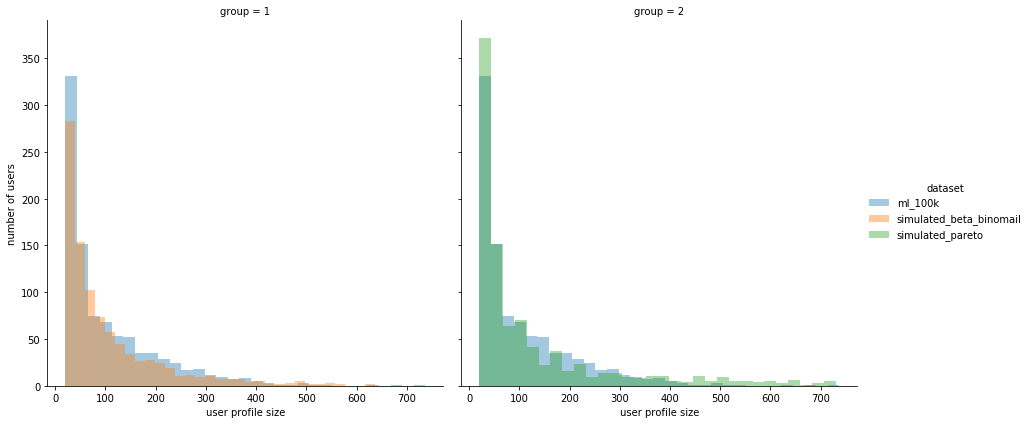

In [57]:
g = sns.FacetGrid(user_profile_models, col='group', hue='dataset', height=6)
g = (g.map(sns.distplot, 'item', kde=False)
     .add_legend()
     .set_axis_labels('user profile size', 'number of users'))
plt.show()

In [58]:
item_popularity_df.head()

item  user  dataset   rank
0     1   452  ml_100k    8.0
1     2   131  ml_100k  239.0
2     3    90  ml_100k  372.0
3     4   209  ml_100k  107.0
4     5    86  ml_100k  388.0

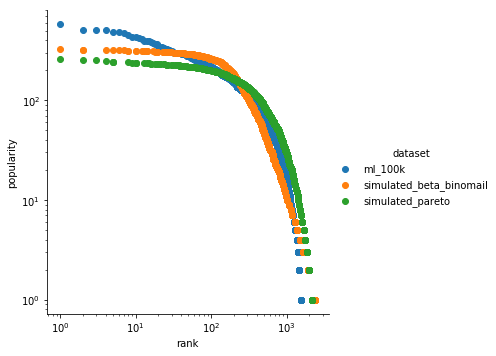

In [59]:
g = sns.FacetGrid(item_popularity_df, hue='dataset', height=5)
g = (g.map(plt.scatter, 'rank', 'user')
     .set(xscale='log', yscale='log')
     .set_axis_labels('rank', 'popularity')
     .add_legend())

In [60]:
count_popularity.head()

dataset  user  count
0  ml_100k     1    141
1  ml_100k     2     68
2  ml_100k     3     60
3  ml_100k     4     64
4  ml_100k     5     51

In [50]:
count_popularity_model1 = count_popularity[count_popularity['dataset'].isin(['ml_100k', 'simulated_beta_binomail'])].copy()
count_popularity_model1['group'] = 1
count_popularity_model2 = count_popularity[count_popularity['dataset'].isin(['ml_100k', 'simulated_pareto'])].copy()
count_popularity_model2['group'] = 2
count_popularity_models = pd.concat([count_popularity_model1, count_popularity_model2])

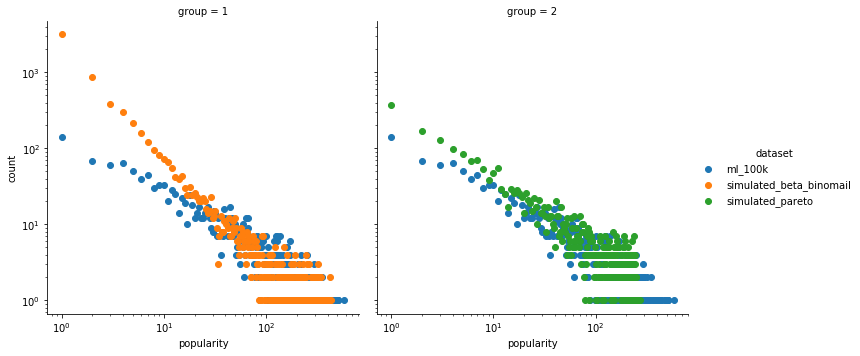

In [51]:
g = sns.FacetGrid(count_popularity_models, col='group', hue='dataset', height=5)
g = (g.map(plt.scatter, 'user', 'count')
     .set(xscale='log', yscale='log')
     .set_axis_labels('popularity', 'count').add_legend())

In [246]:
from scipy.stats import entropy

In [247]:
tall_popularity_count = count_popularity_model1.pivot_table(index='user', columns='dataset', values='count')

In [248]:
p = np.ones(max(tall_popularity_count['ml_100k'].dropna().index))

In [249]:
p[tall_popularity_count['ml_100k'].dropna().index.values - 1] += tall_popularity_count['ml_100k'].dropna().values

In [250]:
p /= p.sum()

In [251]:
q = np.ones(max(tall_popularity_count['simulated_beta_binomail'].dropna().index))

In [252]:
q[tall_popularity_count['simulated_beta_binomail'].dropna().index.values - 1] += tall_popularity_count['simulated_beta_binomail'].dropna().values

In [253]:
q /= q.sum()

In [254]:
lb = min(len(q), len(p))

In [255]:
entropy(q[:lb], p[:lb])

0.09075708186382384

In [256]:
tall_popularity_count = count_popularity_model1.pivot_table(index='user', columns='dataset', values='count', fill_value=0)

In [257]:
p = tall_popularity_count['ml_100k'] + 1

In [258]:
p /= p.sum()

In [259]:
q = tall_popularity_count['simulated_beta_binomail'] + 1

In [260]:
q /= q.sum()

In [261]:
entropy(q, p)

0.23545846119972072